In [ ]:
import os

images_dir = '/content/drive/MyDrive/fashion/women/bags'
all_image_paths = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f'Total images: {len(all_image_paths)}')


Total images: 1252


In [ ]:
import tensorflow as tf

def preprocess_image(img_path, size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img


In [ ]:
from tensorflow.keras import layers, Model, Input

def build_embedding_model(input_shape=(224, 224, 3), embedding_dim=128):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    model = Model(inputs, x)
    return model

embedding_model = build_embedding_model()


In [ ]:
embedding_dim = 128

def triplet_loss(margin=0.2):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, :embedding_dim], y_pred[:, embedding_dim:2*embedding_dim], y_pred[:, 2*embedding_dim:]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss

anchor_input = Input(shape=(224, 224, 3), name='anchor')
pos_input = Input(shape=(224, 224, 3), name='positive')
neg_input = Input(shape=(224, 224, 3), name='negative')

encoded_anchor = embedding_model(anchor_input)
encoded_positive = embedding_model(pos_input)
encoded_negative = embedding_model(neg_input)

merged_output = layers.Concatenate(axis=1)([encoded_anchor, encoded_positive, encoded_negative])

triplet_net = Model(inputs=[anchor_input, pos_input, neg_input], outputs=merged_output)
triplet_net.compile(optimizer='adam', loss=triplet_loss())


In [ ]:
import numpy as np
import random

# Prepare mapping from class/category to image list
def prepare_class_dict(image_paths):
    class_dict = {}
    for path in image_paths:
        cls = os.path.basename(os.path.dirname(path))  # folder name as class
        if cls not in class_dict:
            class_dict[cls] = []
        class_dict[cls].append(path)
    return class_dict

class_dict = prepare_class_dict(all_image_paths)

def triplet_generator(class_dict, batch_size=32, input_size=(224,224,3)):
    classes = list(class_dict.keys())
    while True:
        anchor_images = []
        positive_images = []
        negative_images = []

        for _ in range(batch_size):
            chosen_class = random.choice(classes)
            negative_class = random.choice([c for c in classes if c != chosen_class])

            anchor, positive = random.sample(class_dict[chosen_class], 2)
            negative = random.choice(class_dict[negative_class])

            # Preprocess images
            anchor_images.append(preprocess_image(anchor, input_size[:2]))
            positive_images.append(preprocess_image(positive, input_size[:2]))
            negative_images.append(preprocess_image(negative, input_size[:2]))

        yield [np.array(anchor_images), np.array(positive_images), np.array(negative_images)], np.zeros(batch_size)


In [ ]:
for cls, imgs in class_dict.items():
    print(f"Class '{cls}': {len(imgs)} images")


Class 'bags': 1252 images


In [ ]:
class_dict = {cls: imgs for cls, imgs in class_dict.items() if len(imgs) > 1}


In [ ]:
def prepare_class_dict(image_paths):
    class_dict = {}
    for path in image_paths:
        cls = os.path.basename(os.path.dirname(path))
        if cls not in class_dict:
            class_dict[cls] = []
        class_dict[cls].append(path)
    # Remove classes with not enough images
    class_dict = {cls: imgs for cls, imgs in class_dict.items() if len(imgs) > 1}
    return class_dict


In [ ]:
import numpy as np
import random
import tensorflow as tf

def triplet_generator(class_dict, batch_size=32, input_size=(224, 224, 3)):
    classes = list(class_dict.keys())
    print(f"Available classes: {len(classes)}")

    while True:
        anchor_images = []
        positive_images = []
        negative_images = []

        attempts = 0
        max_attempts = batch_size * 10  # avoid infinite loops

        while len(anchor_images) < batch_size and attempts < max_attempts:
            attempts += 1

            chosen_class = random.choice(classes)
            if len(class_dict[chosen_class]) < 2:
                # Not enough images for anchor-positive pair
                continue

            negative_classes = [c for c in classes if c != chosen_class and len(class_dict[c]) > 0]
            if not negative_classes:
                # No negative class available, skip
                continue

            negative_class = random.choice(negative_classes)

            try:
                anchor, positive = random.sample(class_dict[chosen_class], 2)
                negative = random.choice(class_dict[negative_class])
            except ValueError:
                # Catch any unexpected sample errors
                continue

            try:
                anchor_img = preprocess_image(anchor, input_size[:2]).numpy()
                positive_img = preprocess_image(positive, input_size[:2]).numpy()
                negative_img = preprocess_image(negative, input_size[:2]).numpy()
            except Exception as e:
                # Issue loading image, skip
                print(f"Error loading images: {e}")
                continue

            anchor_images.append(anchor_img)
            positive_images.append(positive_img)
            negative_images.append(negative_img)

        if len(anchor_images) == 0:
            print("Warning: Could not generate any triplets in batch, retrying...")
            continue

        yield [np.array(anchor_images), np.array(positive_images), np.array(negative_images)], np.zeros(len(anchor_images))


In [ ]:
for cls, imgs in class_dict.items():
    print(f"{cls}: {len(imgs)} images")


bags: 1252 images


In [ ]:
import os
import shutil
import random

bags_dir = '/content/drive/MyDrive/fashion/women/bags'
output_dir = '/content/drive/MyDrive/fashion/women/bags_split'

num_classes = 10  # number of artificial classes, adjust as needed

# Create subfolders for classes
for i in range(num_classes):
    class_dir = os.path.join(output_dir, f'class_{i}')
    os.makedirs(class_dir, exist_ok=True)

# List all images
all_images = [f for f in os.listdir(bags_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(all_images)

# Split images into classes roughly evenly
chunks = [all_images[i::num_classes] for i in range(num_classes)]

# Move or copy images to class folders
for class_idx, chunk in enumerate(chunks):
    class_path = os.path.join(output_dir, f'class_{class_idx}')
    for img_name in chunk:
        src_path = os.path.join(bags_dir, img_name)
        dst_path = os.path.join(class_path, img_name)
        shutil.copy2(src_path, dst_path)  # copy instead of move to preserve original

print(f"Split {len(all_images)} images into {num_classes} classes in {output_dir}")


Split 1252 images into 10 classes in /content/drive/MyDrive/fashion/women/bags_split


In [ ]:
def prepare_class_dict(image_dir):
    class_dict = {}
    for cls in os.listdir(image_dir):
        cls_dir = os.path.join(image_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        images = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(images) > 1:  # Only keep classes with at least 2 images
            class_dict[cls] = images
    return class_dict

new_data_dir = '/content/drive/MyDrive/fashion/women/bags_split'
class_dict = prepare_class_dict(new_data_dir)


In [ ]:
all_image_paths = []
for imgs in class_dict.values():
    all_image_paths.extend(imgs)


In [ ]:
import numpy as np
import random
import tensorflow as tf

def triplet_generator(class_dict, batch_size=32, input_size=(224, 224, 3)):
    classes = list(class_dict.keys())
    print(f"Available classes: {len(classes)}")

    while True:
        anchor_images = []
        positive_images = []
        negative_images = []

        attempts = 0
        max_attempts = batch_size * 10  # avoid infinite loops

        while len(anchor_images) < batch_size and attempts < max_attempts:
            attempts += 1

            chosen_class = random.choice(classes)
            if len(class_dict[chosen_class]) < 2:
                continue

            negative_classes = [c for c in classes if c != chosen_class and len(class_dict[c]) > 0]
            if not negative_classes:
                continue

            negative_class = random.choice(negative_classes)

            try:
                anchor, positive = random.sample(class_dict[chosen_class], 2)
                negative = random.choice(class_dict[negative_class])
            except ValueError:
                continue

            try:
                anchor_img = preprocess_image(anchor, input_size[:2]).numpy()
                positive_img = preprocess_image(positive, input_size[:2]).numpy()
                negative_img = preprocess_image(negative, input_size[:2]).numpy()
            except Exception as e:
                print(f"Error loading images: {e}")
                continue

            anchor_images.append(anchor_img)
            positive_images.append(positive_img)
            negative_images.append(negative_img)

        if len(anchor_images) == 0:
            print("Warning: Could not generate any triplets in batch, retrying...")
            continue

        # Yield tuple of inputs and dummy labels properly
        yield (
            (np.array(anchor_images), np.array(positive_images), np.array(negative_images)),
            np.zeros(len(anchor_images))  # dummy labels
        )

# Define output signature for tf.data.Dataset.from_generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # anchor batch
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # positive batch
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # negative batch
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)  # dummy labels
)

# Wrap generator as tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(class_dict, batch_size=32),
    output_signature=output_signature
)

batch_size = 32
steps_per_epoch = len(all_image_paths) // batch_size

# Train
triplet_net.fit(train_dataset, epochs=10, steps_per_epoch=steps_per_epoch)


Epoch 1/10
Available classes: 10
 13/182 ━━━━━━━━━━━━━━━━━━━━ 22:44 8s/step - loss: 0.2000

KeyboardInterrupt: 

In [ ]:
import numpy as np
import random
import tensorflow as tf

def triplet_generator(class_dict, batch_size=32, input_size=(224, 224, 3)):
    classes = list(class_dict.keys())
    print(f"Available classes: {len(classes)}")

    while True:
        anchor_images = []
        positive_images = []
        negative_images = []

        attempts = 0
        max_attempts = batch_size * 10  # avoid infinite loops

        while len(anchor_images) < batch_size and attempts < max_attempts:
            attempts += 1

            chosen_class = random.choice(classes)
            if len(class_dict[chosen_class]) < 2:
                continue

            negative_classes = [c for c in classes if c != chosen_class and len(class_dict[c]) > 0]
            if not negative_classes:
                continue

            negative_class = random.choice(negative_classes)

            try:
                anchor, positive = random.sample(class_dict[chosen_class], 2)
                negative = random.choice(class_dict[negative_class])
            except ValueError:
                continue

            try:
                anchor_img = preprocess_image(anchor, input_size[:2]).numpy()
                positive_img = preprocess_image(positive, input_size[:2]).numpy()
                negative_img = preprocess_image(negative, input_size[:2]).numpy()
            except Exception as e:
                print(f"Error loading images: {e}")
                continue

            anchor_images.append(anchor_img)
            positive_images.append(positive_img)
            negative_images.append(negative_img)

        if len(anchor_images) == 0:
            print("Warning: Could not generate any triplets in batch, retrying...")
            continue

        print(f"Yielding batch with {len(anchor_images)} triplets after {attempts} attempts")

        yield (
            (np.array(anchor_images), np.array(positive_images), np.array(negative_images)),
            np.zeros(len(anchor_images))
        )


In [ ]:
from tensorflow.keras import layers, Model, Input
import tensorflow as tf

# Embedding model: outputs normalized embeddings (128-dimensional)
def build_embedding_model(input_shape=(224, 224, 3), embedding_dim=128):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    model = Model(inputs, x)
    return model

embedding_model = build_embedding_model()

# Triplet loss with margin
def triplet_loss(margin=0.2):
    def loss(y_true, y_pred):
        embedding_dim = 128
        anchor = y_pred[:, 0:embedding_dim]
        positive = y_pred[:, embedding_dim:2*embedding_dim]
        negative = y_pred[:, 2*embedding_dim:3*embedding_dim]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss

# Define triplet network that outputs concatenated embeddings
anchor_input = Input(name='anchor', shape=(224, 224, 3))
positive_input = Input(name='positive', shape=(224, 224, 3))
negative_input = Input(name='negative', shape=(224, 224, 3))

encoded_anchor = embedding_model(anchor_input)
encoded_positive = embedding_model(positive_input)
encoded_negative = embedding_model(negative_input)

merged_output = layers.Concatenate(axis=1)([encoded_anchor, encoded_positive, encoded_negative])

triplet_net = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)

triplet_net.compile(optimizer='adam', loss=triplet_loss())


In [ ]:
import numpy as np
import random
import tensorflow as tf

# Your preprocess_image function (replace with your implementation)
def preprocess_image(image_path, size=(224, 224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def triplet_generator(class_dict, batch_size=32, input_size=(224, 224, 3)):
    classes = list(class_dict.keys())
    print(f"Available classes: {len(classes)}")

    while True:
        anchor_images = []
        positive_images = []
        negative_images = []

        attempts = 0
        max_attempts = batch_size * 10  # avoid infinite loops

        while len(anchor_images) < batch_size and attempts < max_attempts:
            attempts += 1

            chosen_class = random.choice(classes)
            if len(class_dict[chosen_class]) < 2:
                continue

            negative_classes = [c for c in classes if c != chosen_class and len(class_dict[c]) > 0]
            if not negative_classes:
                continue

            negative_class = random.choice(negative_classes)

            try:
                anchor, positive = random.sample(class_dict[chosen_class], 2)
                negative = random.choice(class_dict[negative_class])
            except ValueError:
                continue

            try:
                anchor_img = preprocess_image(anchor, input_size[:2]).numpy()
                positive_img = preprocess_image(positive, input_size[:2]).numpy()
                negative_img = preprocess_image(negative, input_size[:2]).numpy()
            except Exception as e:
                print(f"Error loading images: {e}")
                continue

            anchor_images.append(anchor_img)
            positive_images.append(positive_img)
            negative_images.append(negative_img)

        if len(anchor_images) == 0:
            print("Warning: Could not generate any triplets in batch, retrying...")
            continue

        print(f"Yielding batch with {len(anchor_images)} triplets after {attempts} attempts")

        yield (
            (np.array(anchor_images), np.array(positive_images), np.array(negative_images)),
            np.zeros(len(anchor_images))  # dummy labels
        )


# Define output signature matching the yielded structure of the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # anchor batch
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # positive batch
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # negative batch
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)  # dummy labels
)


# Prepare your class_dict (mapping class name -> list of file paths) before running this
# Example:
# class_dict = {
#     "class_0": ["/path/to/class_0/img1.jpg", "/path/to/class_0/img2.jpg", ...],
#     "class_1": ["/path/to/class_1/img1.jpg", "/path/to/class_1/img2.jpg", ...],
#     ...
# }

batch_size = 16
steps_per_epoch = 20  # adjust depending on dataset size and training speed
epochs = 5

# Create tf.data.Dataset from generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(class_dict, batch_size=batch_size),
    output_signature=output_signature
)

# Train your triplet network
triplet_net.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch)


Epoch 1/5
Available classes: 10
Yielding batch with 16 triplets after 16 attempts
Yielding batch with 16 triplets after 16 attempts
 2/20 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - loss: 0.1902 Yielding batch with 16 triplets after 16 attempts
Yielding batch with 16 triplets after 16 attempts
 3/20 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - loss: 0.1926Yielding batch with 16 triplets after 16 attempts
 4/20 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - loss: 0.1941Yielding batch with 16 triplets after 16 attempts
 5/20 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 0.1955Yielding batch with 16 triplets after 16 attempts
 7/20 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 0.1975 Yielding batch with 16 triplets after 16 attempts
Yielding batch with 16 triplets after 16 attempts
 8/20 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - loss: 0.1982Yielding batch with 16 triplets after 16 attempts
10/20 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - loss: 0.1991Yielding batch with 16 triplets after 16 attempts
Yielding batch with 16 triplets after 16 

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# --- Step 1: Prepare class dictionary ---
def prepare_class_dict(data_dir):
    class_dict = {}
    for cls in os.listdir(data_dir):
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        images = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(images) > 1:
            class_dict[cls] = images
    return class_dict

data_dir = '/content/drive/MyDrive/fashion/women/bags_split'  # your data folder with subfolders
class_dict = prepare_class_dict(data_dir)
print(f"Available classes: {len(class_dict)}")

# Gather all images for steps_per_epoch calculation
all_image_paths = [img for imgs in class_dict.values() for img in imgs]

# --- Step 2: Image preprocessing ---
def preprocess_image(image_path, size=(224, 224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# --- Step 3: Triplet generator ---
def triplet_generator(class_dict, batch_size=16, input_size=(224, 224, 3)):
    classes = list(class_dict.keys())
    print(f"Using classes: {len(classes)}")
    while True:
        anchor_images, positive_images, negative_images = [], [], []
        attempts = 0
        max_attempts = batch_size * 10
        while len(anchor_images) < batch_size and attempts < max_attempts:
            attempts += 1
            chosen_class = random.choice(classes)
            if len(class_dict[chosen_class]) < 2:
                continue
            negative_classes = [c for c in classes if c != chosen_class and len(class_dict[c]) > 0]
            if not negative_classes:
                continue
            negative_class = random.choice(negative_classes)
            try:
                anchor, positive = random.sample(class_dict[chosen_class], 2)
                negative = random.choice(class_dict[negative_class])
            except ValueError:
                continue
            try:
                anchor_img = preprocess_image(anchor, input_size[:2]).numpy()
                positive_img = preprocess_image(positive, input_size[:2]).numpy()
                negative_img = preprocess_image(negative, input_size[:2]).numpy()
            except Exception as e:
                print(f"Error loading images: {e}")
                continue
            anchor_images.append(anchor_img)
            positive_images.append(positive_img)
            negative_images.append(negative_img)
        if len(anchor_images) == 0:
            print("Warning: Could not generate any triplets in batch, retrying...")
            continue
        print(f"Yielding batch with {len(anchor_images)} samples after {attempts} attempts")
        yield ((np.array(anchor_images), np.array(positive_images), np.array(negative_images)),
               np.zeros(len(anchor_images)))

# --- Step 4: Output signature for tf.data.Dataset ---
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# --- Step 5: Build the embedding model ---
def build_embedding_model(input_shape=(224, 224, 3), embedding_dim=128):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    model = Model(inputs, x)
    return model

embedding_model = build_embedding_model()

# --- Step 6: Triplet network model ---
def triplet_loss(margin=0.2):
    def loss(y_true, y_pred):
        embed_dim = 128
        anchor = y_pred[:, 0:embed_dim]
        positive = y_pred[:, embed_dim:2*embed_dim]
        negative = y_pred[:, 2*embed_dim:3*embed_dim]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss

anchor_input = Input(shape=(224, 224, 3), name='anchor')
positive_input = Input(shape=(224, 224, 3), name='positive')
negative_input = Input(shape=(224, 224, 3), name='negative')

anchor_emb = embedding_model(anchor_input)
positive_emb = embedding_model(positive_input)
negative_emb = embedding_model(negative_input)

merged_output = layers.Concatenate(axis=1)([anchor_emb, positive_emb, negative_emb])

triplet_net = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)

triplet_net.compile(optimizer='adam', loss=triplet_loss())

# --- Step 7: Create tf.data.Dataset ---
batch_size = 16
steps_per_epoch = 20
epochs = 5

train_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(class_dict, batch_size=batch_size),
    output_signature=output_signature
)

# --- Step 8: Train ---
triplet_net.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch)


Available classes: 10
Epoch 1/5
Using classes: 10
Yielding batch with 16 samples after 16 attempts
Yielding batch with 16 samples after 16 attempts
 1/20 ━━━━━━━━━━━━━━━━━━━━ 4:10 13s/step - loss: 0.1942Yielding batch with 16 samples after 16 attempts
 2/20 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - loss: 0.1930 Yielding batch with 16 samples after 16 attempts
 3/20 ━━━━━━━━━━━━━━━━━━━━ 1:18 5s/step - loss: 0.1906Yielding batch with 16 samples after 16 attempts
 4/20 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - loss: 0.1907Yielding batch with 16 samples after 16 attempts
 5/20 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - loss: 0.1924Yielding batch with 16 samples after 16 attempts
 6/20 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - loss: 0.1949Yielding batch with 16 samples after 16 attempts
 7/20 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - loss: 0.1965 Yielding batch with 16 samples after 16 attempts
 8/20 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 0.1971Yielding batch with 16 samples after 16 attempts
 9/20 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import numpy as np
import tensorflow as tf

embeddings = []
for path in all_image_paths:
    img = preprocess_image(path)
    img = tf.expand_dims(img, 0)
    emb = embedding_model(img, training=False).numpy()
    embeddings.append(emb[0])

embeddings = np.array(embeddings).astype('float32')
print(f"Shape of embeddings: {embeddings.shape}")


Shape of embeddings: (2364, 128)


In [ ]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 63.8 MB/s eta 0:00:00


In [ ]:
import faiss

faiss_index = faiss.IndexFlatIP(embeddings.shape[1])  # For normalized embeddings
faiss_index.add(embeddings)

faiss.write_index(faiss_index, '/content/drive/MyDrive/bags_fashion_index.faiss')
print("FAISS index saved!")


FAISS index saved!


In [ ]:
embedding_model.save('/content/drive/MyDrive/triplet_bag_embedding_model.h5')

print("Embedding model saved!")


Embedding model saved!


In [ ]:
query_image_path = '/content/drive/MyDrive/fashion/women/bags_split/class_0/wbag1.png'
query_img = preprocess_image(query_image_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb = query_emb / np.linalg.norm(query_emb)


In [ ]:
import faiss

faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index.faiss')

# Find top-k (e.g., 5) closest images
D, I = faiss_index.search(query_emb.astype('float32'), k=5)
similar_image_paths = [all_image_paths[idx] for idx in I[0]]
print("Top 5 similar images:", similar_image_paths)


Top 5 similar images: ['/content/drive/MyDrive/fashion/women/bags_split/class_2/wbag1.png', '/content/drive/MyDrive/fashion/women/bags_split/class_0/wbag1.png', '/content/drive/MyDrive/fashion/women/bags_split/class_9/wbag17097.png', '/content/drive/MyDrive/fashion/women/bags_split/class_0/wbag17097.png', '/content/drive/MyDrive/fashion/women/bags_split/class_5/wbag16748.png']


Top 5 similar images: ['/content/drive/MyDrive/fashion/women/bags_split/class_2/wbag10000.png', '/content/drive/MyDrive/fashion/women/bags_split/class_0/wbag10000.png', '/content/drive/MyDrive/fashion/women/bags_split/class_5/wbag15161.png', '/content/drive/MyDrive/fashion/women/bags_split/class_1/wbag15161.png', '/content/drive/MyDrive/fashion/women/bags_split/class_5/wbag15774.png']


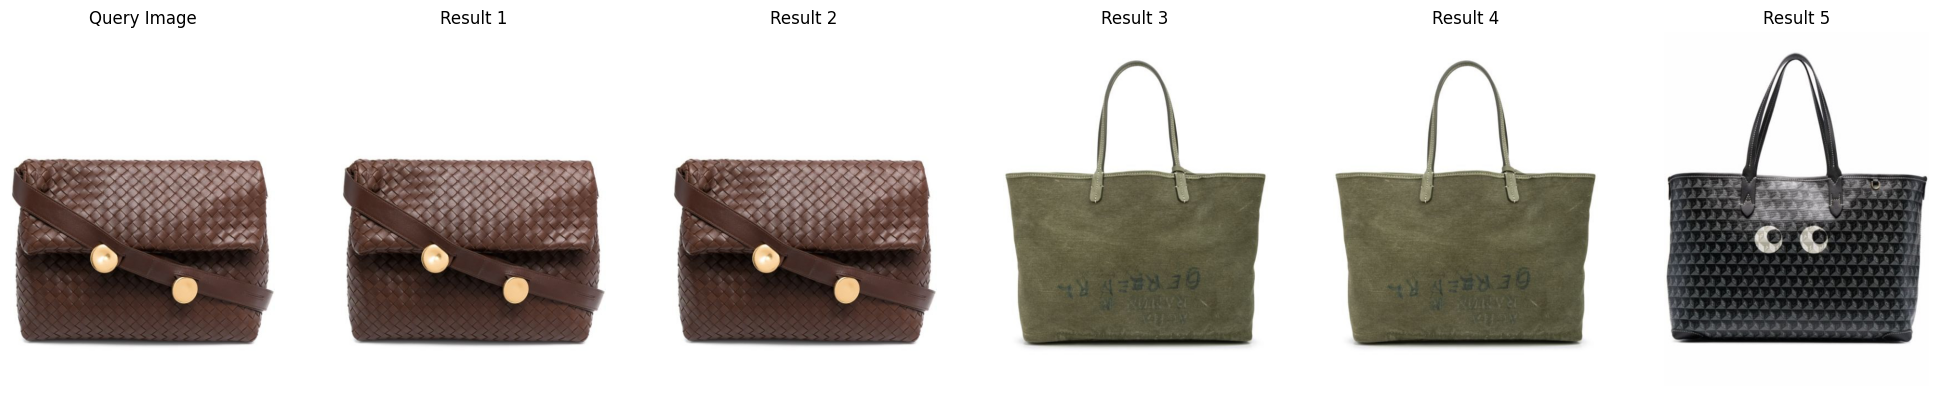

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import faiss

# Preprocess query image and get embedding
query_image_path = '/content/drive/MyDrive/fashion/women/bags_split/class_0/wbag10000.png'
query_img = preprocess_image(query_image_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb = query_emb / np.linalg.norm(query_emb)

# Load faiss index
faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index.faiss')

# Search top 5 similar images
D, I = faiss_index.search(query_emb.astype('float32'), k=5)
similar_image_paths = [all_image_paths[idx] for idx in I[0]]

print("Top 5 similar images:", similar_image_paths)

# Show query and similar images
plt.figure(figsize=(20, 4))

plt.subplot(1, 6, 1)
plt.imshow(Image.open(query_image_path))
plt.title('Query Image')
plt.axis('off')

for i, sim_path in enumerate(similar_image_paths):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import hashlib
from shutil import move

def file_hash(file_path, chunk_size=65536):
    hash_algo = hashlib.md5()
    with open(file_path, 'rb') as f:
        while chunk := f.read(chunk_size):
            hash_algo.update(chunk)
    return hash_algo.hexdigest()

def remove_duplicates(src_dir, dup_dir):
    os.makedirs(dup_dir, exist_ok=True)
    seen_hashes = {}
    num_moved = 0

    for root, dirs, files in os.walk(src_dir):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, filename)
                h = file_hash(file_path)
                if h in seen_hashes:
                    # Duplicate found, move to duplicate folder
                    dst_path = os.path.join(dup_dir, filename)
                    move(file_path, dst_path)
                    num_moved += 1
                else:
                    seen_hashes[h] = file_path

    print(f"Moved {num_moved} duplicate images to {dup_dir}")

# Usage:
src_dataset_dir = '/content/drive/MyDrive/fashion/women/bags_split'  # Your dataset folder
duplicates_dir = '/content/drive/MyDrive/fashion/women/bags_duplicates'  # Where duplicates will be moved

remove_duplicates(src_dataset_dir, duplicates_dir)


Moved 1121 duplicate images to /content/drive/MyDrive/fashion/women/bags_duplicates


In [ ]:
import os

# Filter out non-existent files
all_image_paths = [p for p in all_image_paths if os.path.exists(p)]
print(f"Valid image paths: {len(all_image_paths)}")

# Then extract embeddings as before
embeddings = []
for path in all_image_paths:
    img = preprocess_image(path)
    img = tf.expand_dims(img, 0)
    emb = embedding_model(img, training=False).numpy()
    embeddings.append(emb[0])


Valid image paths: 1243


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf

# Compute embeddings for valid images
embeddings = []
for path in all_image_paths:
    img = preprocess_image(path)
    img = tf.expand_dims(img, 0)
    emb = embedding_model(img, training=False).numpy()
    embeddings.append(emb[0])
embeddings = np.array(embeddings).astype('float32')


k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(embeddings)


clustered_class_dict = {}
for idx, label in enumerate(labels):
    cls = f"class_{label}"
    if cls not in clustered_class_dict:
        clustered_class_dict[cls] = []
    clustered_class_dict[cls].append(all_image_paths[idx])

print(f"Created {len(clustered_class_dict)} clusters for triplet training.")


Created 10 clusters for triplet training.


In [ ]:
batch_size = 16
epochs = 5
steps_per_epoch = 20
train_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(clustered_class_dict, batch_size=batch_size),
    output_signature=output_signature
)

triplet_net.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch)


Epoch 1/5


UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
NameError: name 'clustered_class_dict' is not defined
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 865, in get_iterator
    return self._iterators[iterator_id]
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^

KeyError: np.int64(0)


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 867, in get_iterator
    iterator = iter(self._generator(*self._args.pop(iterator_id)))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipython-input-2197322339.py", line 5, in <lambda>
    lambda: triplet_generator(clustered_class_dict, batch_size=batch_size),
                              ^^^^^^^^^^^^^^^^^^^^

NameError: name 'clustered_class_dict' is not defined


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_53567]

In [ ]:
import numpy as np
import tensorflow as tf

embeddings = []
for path in all_image_paths:
    img = preprocess_image(path)
    img = tf.expand_dims(img, 0)
    emb = embedding_model(img, training=False).numpy()
    embeddings.append(emb[0])

embeddings = np.array(embeddings).astype('float32')
print(f"Extracted embeddings shape: {embeddings.shape}")


Extracted embeddings shape: (1243, 128)


In [ ]:
import faiss

faiss_index = faiss.IndexFlatIP(embeddings.shape[1])  # For normalized embeddings
faiss_index.add(embeddings)
faiss.write_index(faiss_index, '/content/drive/MyDrive/bags_fashion_index_new.faiss')
print("New FAISS index saved.")


New FAISS index saved.


In [ ]:
embedding_model.save('/content/drive/MyDrive/triplet_bag_embedding_model_v2.keras')
print("Trained embedding model saved.")


Trained embedding model saved.


Top 5 similar images: ['/content/drive/MyDrive/fashion/women/bags_split/class_0/wbag1.png', '/content/drive/MyDrive/fashion/women/bags_split/class_0/wbag17097.png', '/content/drive/MyDrive/fashion/women/bags_split/class_0/wbag16748.png', '/content/drive/MyDrive/fashion/women/bags_split/class_0/wbag10270.png', '/content/drive/MyDrive/fashion/women/bags_split/class_0/wbag10407.png']


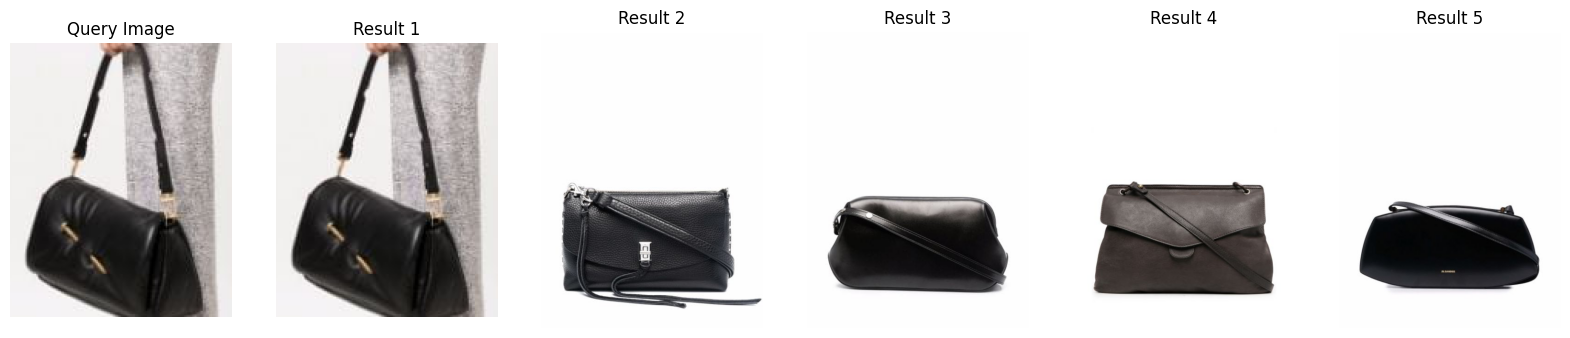

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

query_image_path = all_image_paths[0]  # You can change this to any image path
query_img = preprocess_image(query_image_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb = query_emb / np.linalg.norm(query_emb)

faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')

D, I = faiss_index.search(query_emb.astype('float32'), k=5)
similar_image_paths = [all_image_paths[idx] for idx in I[0]]
print("Top 5 similar images:", similar_image_paths)

plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(query_image_path))
plt.title('Query Image')
plt.axis('off')

for i, sim_path in enumerate(similar_image_paths):
    plt.subplot(1, 6, i+2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.show()


Saving wbag425.png to wbag425.png


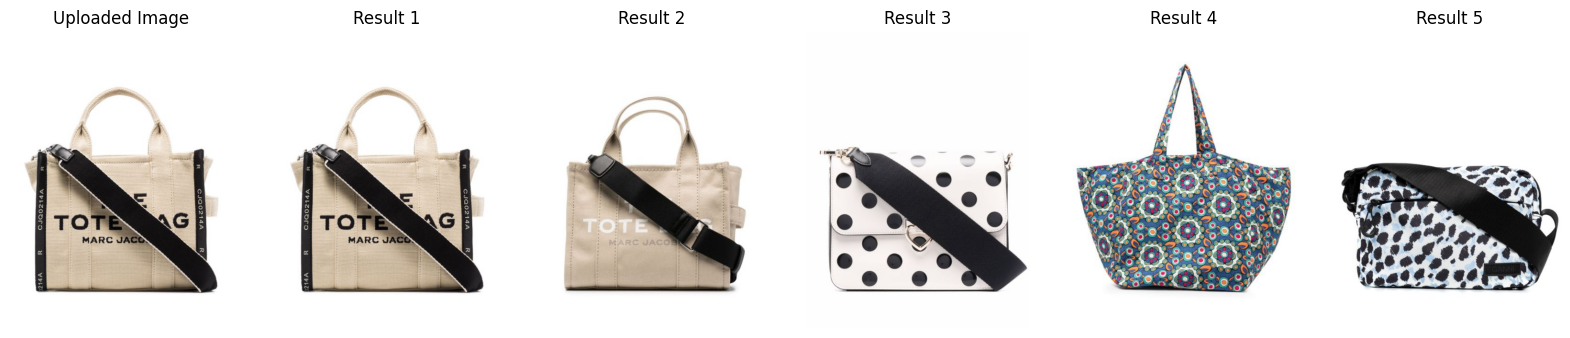

In [ ]:
from google.colab import files
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Upload image
uploaded = files.upload()

# Get uploaded file path (only one file assumed)
uploaded_path = list(uploaded.keys())[0]

# Load, preprocess, embed
query_img = preprocess_image(uploaded_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb = query_emb / np.linalg.norm(query_emb)

# Search similarity with existing index
import faiss
faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')

D, I = faiss_index.search(query_emb.astype('float32'), k=5)
similar_image_paths = [all_image_paths[idx] for idx in I[0]]

# Display uploaded image and similar results
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(similar_image_paths):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.show()


Saving wbag17079.png to wbag17079.png


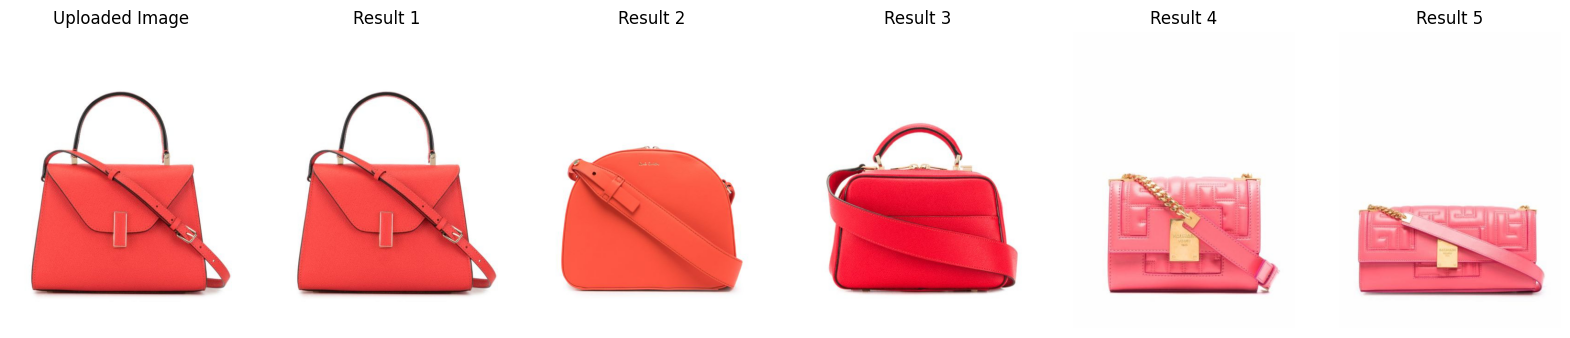

In [ ]:
from google.colab import files
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Upload image
uploaded = files.upload()

# Get uploaded file path (only one file assumed)
uploaded_path = list(uploaded.keys())[0]

# Load, preprocess, embed
query_img = preprocess_image(uploaded_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb = query_emb / np.linalg.norm(query_emb)

# Search similarity with existing index
import faiss
faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')

D, I = faiss_index.search(query_emb.astype('float32'), k=5)
similar_image_paths = [all_image_paths[idx] for idx in I[0]]

# Display uploaded image and similar results
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(similar_image_paths):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.show()


Saving wbag16705.png to wbag16705.png


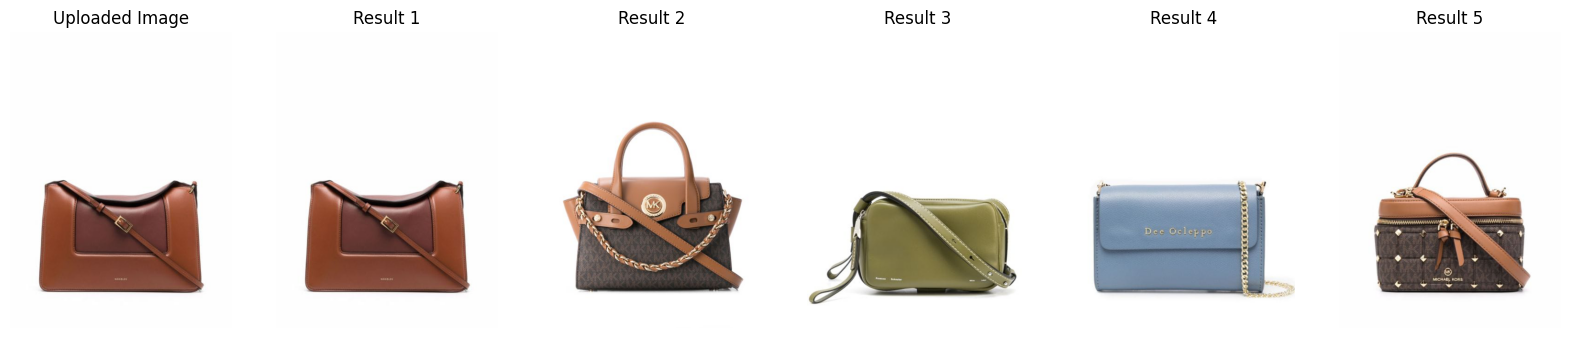

In [ ]:
from google.colab import files
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Upload image
uploaded = files.upload()

# Get uploaded file path (only one file assumed)
uploaded_path = list(uploaded.keys())[0]

# Load, preprocess, embed
query_img = preprocess_image(uploaded_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb = query_emb / np.linalg.norm(query_emb)

# Search similarity with existing index
import faiss
faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')

D, I = faiss_index.search(query_emb.astype('float32'), k=5)
similar_image_paths = [all_image_paths[idx] for idx in I[0]]

# Display uploaded image and similar results
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(similar_image_paths):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.show()


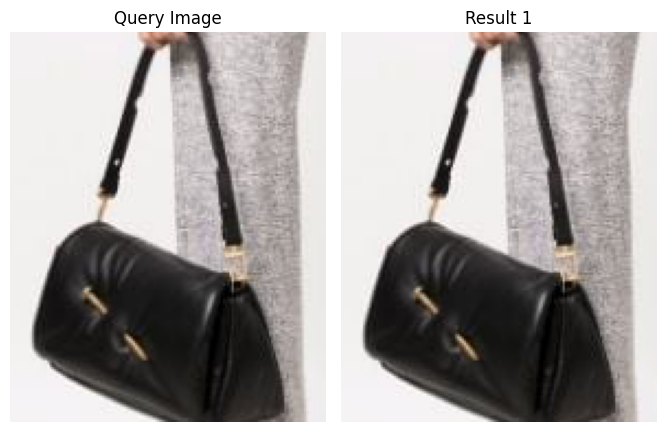

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import cv2
import faiss
import os

# --- Helper function: compute embedding for one image ---
def get_embedding(image_path):
    img = preprocess_image(image_path)
    img = tf.expand_dims(img, 0)
    emb = embedding_model(img, training=False).numpy()
    emb = emb / np.linalg.norm(emb)
    return emb[0]

# --- Helper function: compute color histogram in HSV space ---
def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"File {image_path} not found.")
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist.flatten()

# --- Helper function: compute size from image (area normalized by maximum in dataset) ---
def get_normalized_size(image_path, max_area):
    image = Image.open(image_path)
    return (image.width * image.height) / max_area

# --- Parameters for filtering similarity ---
COLOR_DIST_THRESHOLD = 0.3
SIZE_RATIO_THRESHOLD = 1.5
TOP_K = 20  # number of initial neighbors to query from FAISS before filtering
FINAL_RESULTS = 5  # number of filtered images to display

# Precompute max area in dataset for size normalization
all_areas = [Image.open(p).width * Image.open(p).height for p in all_image_paths]
max_area = max(all_areas)

# Get query image path (change as needed)
query_image_path = '/content/drive/MyDrive/fashion/women/bags/wbag1.png'

# Step 1: Compute query embedding and query color histogram and size
query_emb = get_embedding(query_image_path)
query_hist = get_color_histogram(query_image_path)
query_size = get_normalized_size(query_image_path, max_area)

# Step 2: Load FAISS index and search top-K neighbors based on embedding
faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')
D, I = faiss_index.search(np.expand_dims(query_emb, axis=0).astype('float32'), TOP_K)

# Step 3: Filter results by color and size
candidate_paths = [all_image_paths[idx] for idx in I[0]]
filtered_results = []

for cand_path in candidate_paths:
    cand_hist = get_color_histogram(cand_path)
    cand_size = get_normalized_size(cand_path, max_area)

    # Color distance using correlation distance
    color_dist = cv2.compareHist(query_hist.astype('float32'), cand_hist.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)

    # Size ratio (ensure >= 1)
    size_ratio = max(query_size / cand_size, cand_size / query_size)

    if color_dist < COLOR_DIST_THRESHOLD and size_ratio < SIZE_RATIO_THRESHOLD:
        filtered_results.append(cand_path)

    if len(filtered_results) >= FINAL_RESULTS:
        break

# Step 4: Display query and filtered results
plt.figure(figsize=(20, 5))
plt.subplot(1, FINAL_RESULTS + 1, 1)
plt.imshow(Image.open(query_image_path))
plt.title("Query Image")
plt.axis("off")

for idx, img_path in enumerate(filtered_results):
    plt.subplot(1, FINAL_RESULTS + 1, idx + 2)
    plt.imshow(Image.open(img_path))
    plt.title(f"Result {idx + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Saving wbag451.png to wbag451.png


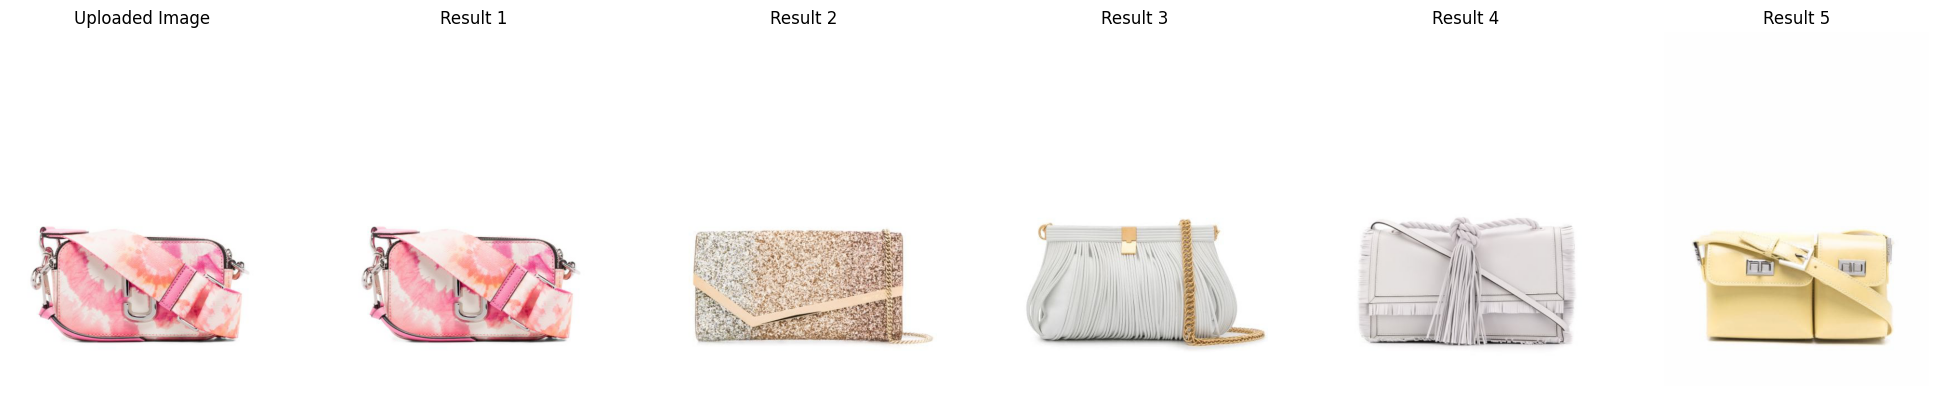

In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import faiss

# Upload image
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

# Preprocess image (consistent with training)
def preprocess_image(img_path, size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Compute HSV color histogram for an image path
def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist.flatten()

# Get embedding for one image path
query_img = preprocess_image(uploaded_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb = query_emb / np.linalg.norm(query_emb)

# Load FAISS index
faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')

# Search top 100 candidates to filter color
TOP_K = 100
D, I = faiss_index.search(query_emb.astype('float32'), k=TOP_K)
candidate_paths = [all_image_paths[idx] for idx in I[0]]

query_hist = get_color_histogram(uploaded_path)
COLOR_DIST_THRESHOLD = 0.5  # Looser threshold to find enough matches

filtered_results = []
for cand_path in candidate_paths:
    if cand_path == uploaded_path:
        continue  # Skip query image itself

    cand_hist = get_color_histogram(cand_path)
    color_dist = cv2.compareHist(query_hist.astype('float32'), cand_hist.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)

    if color_dist < COLOR_DIST_THRESHOLD:
        filtered_results.append(cand_path)

    if len(filtered_results) >= 5:
        break

# Fallback if less than 5 color filtered results - fill up with FAISS top results excluding query
if len(filtered_results) < 5:
    for cand_path in candidate_paths:
        if cand_path != uploaded_path and cand_path not in filtered_results:
            filtered_results.append(cand_path)
        if len(filtered_results) >= 5:
            break

# Display
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(filtered_results):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving wbag468.png to wbag468.png


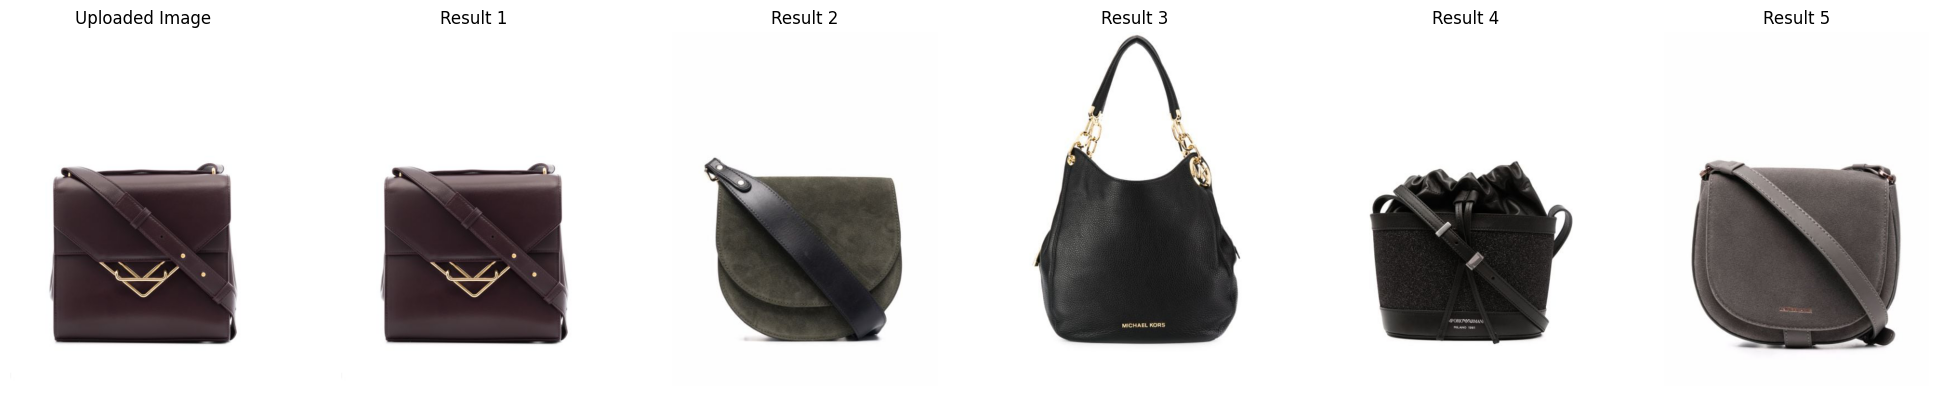

In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import faiss

# --- Upload image ---
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

def preprocess_image(img_path, size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist.flatten()

def get_shape_descriptor(image_path, size=(200, 200)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, size)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    return edges.flatten()

query_img = preprocess_image(uploaded_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb = query_emb / np.linalg.norm(query_emb)

# Load FAISS index
faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')
TOP_K = 100
D, I = faiss_index.search(query_emb.astype('float32'), k=TOP_K)
candidate_paths = [all_image_paths[idx] for idx in I[0]]

query_hist = get_color_histogram(uploaded_path)
query_shape = get_shape_descriptor(uploaded_path)
COLOR_DIST_THRESHOLD = 0.5  # Looser color filter
SHAPE_DIST_THRESHOLD = 60000  # Adjust for strictness; lower = stricter shape match

filtered_results = []
for cand_path in candidate_paths:
    if cand_path == uploaded_path:
        continue  # Skip query image itself

    cand_hist = get_color_histogram(cand_path)
    color_dist = cv2.compareHist(query_hist.astype('float32'), cand_hist.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)

    cand_shape = get_shape_descriptor(cand_path)
    shape_dist = np.sum(np.abs(query_shape - cand_shape))  # L1 distance between edge images

    if color_dist < COLOR_DIST_THRESHOLD and shape_dist < SHAPE_DIST_THRESHOLD:
        filtered_results.append(cand_path)
    if len(filtered_results) >= 5:
        break

# Fallback to top FAISS (embedding matched) results if less than 5 found
if len(filtered_results) < 5:
    for cand_path in candidate_paths:
        if cand_path != uploaded_path and cand_path not in filtered_results:
            filtered_results.append(cand_path)
        if len(filtered_results) >= 5:
            break

# Display
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(filtered_results):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving wbag16826.png to wbag16826.png


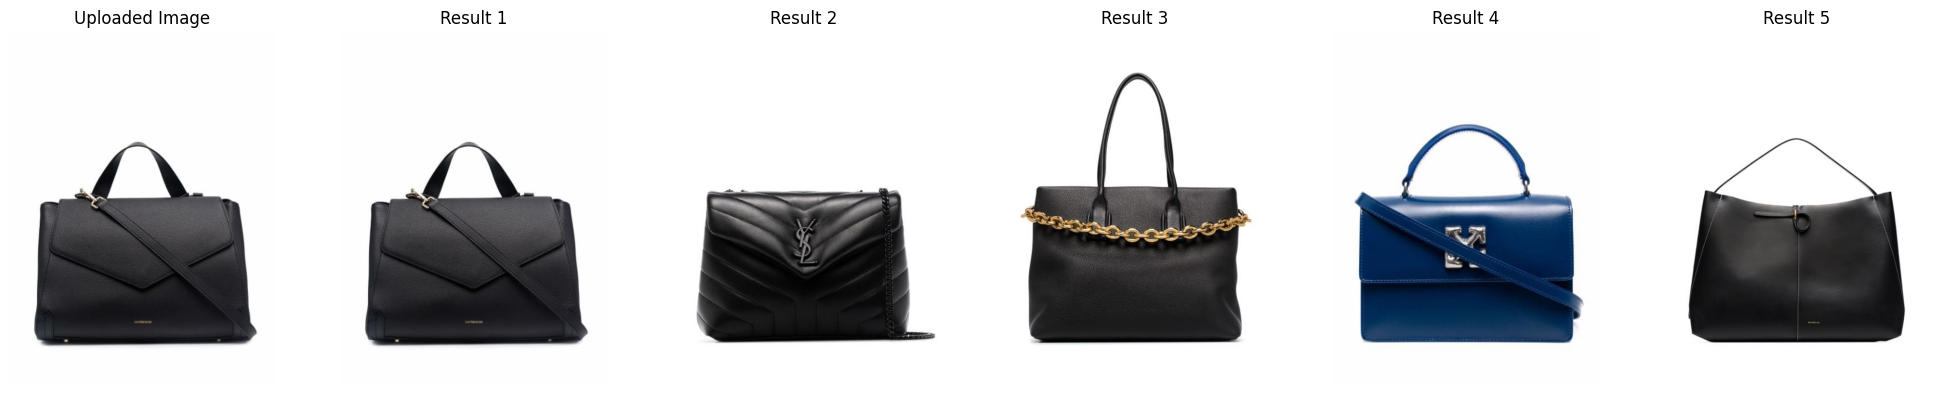

In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import faiss

# --- Upload image ---
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

def preprocess_image(img_path, size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist.flatten()

def get_shape_descriptor(image_path, size=(200, 200)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, size)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    return edges.flatten()

query_img = preprocess_image(uploaded_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb = query_emb / np.linalg.norm(query_emb)

# Load FAISS index
faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')
TOP_K = 100
D, I = faiss_index.search(query_emb.astype('float32'), k=TOP_K)
candidate_paths = [all_image_paths[idx] for idx in I[0]]

query_hist = get_color_histogram(uploaded_path)
query_shape = get_shape_descriptor(uploaded_path)
COLOR_DIST_THRESHOLD = 0.5  # Looser color filter
SHAPE_DIST_THRESHOLD = 60000  # Adjust for strictness; lower = stricter shape match

filtered_results = []
for cand_path in candidate_paths:
    if cand_path == uploaded_path:
        continue  # Skip query image itself

    cand_hist = get_color_histogram(cand_path)
    color_dist = cv2.compareHist(query_hist.astype('float32'), cand_hist.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)

    cand_shape = get_shape_descriptor(cand_path)
    shape_dist = np.sum(np.abs(query_shape - cand_shape))  # L1 distance between edge images

    if color_dist < COLOR_DIST_THRESHOLD and shape_dist < SHAPE_DIST_THRESHOLD:
        filtered_results.append(cand_path)
    if len(filtered_results) >= 5:
        break

# Fallback to top FAISS (embedding matched) results if less than 5 found
if len(filtered_results) < 5:
    for cand_path in candidate_paths:
        if cand_path != uploaded_path and cand_path not in filtered_results:
            filtered_results.append(cand_path)
        if len(filtered_results) >= 5:
            break

# Display
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(filtered_results):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving wbag459.png to wbag459.png


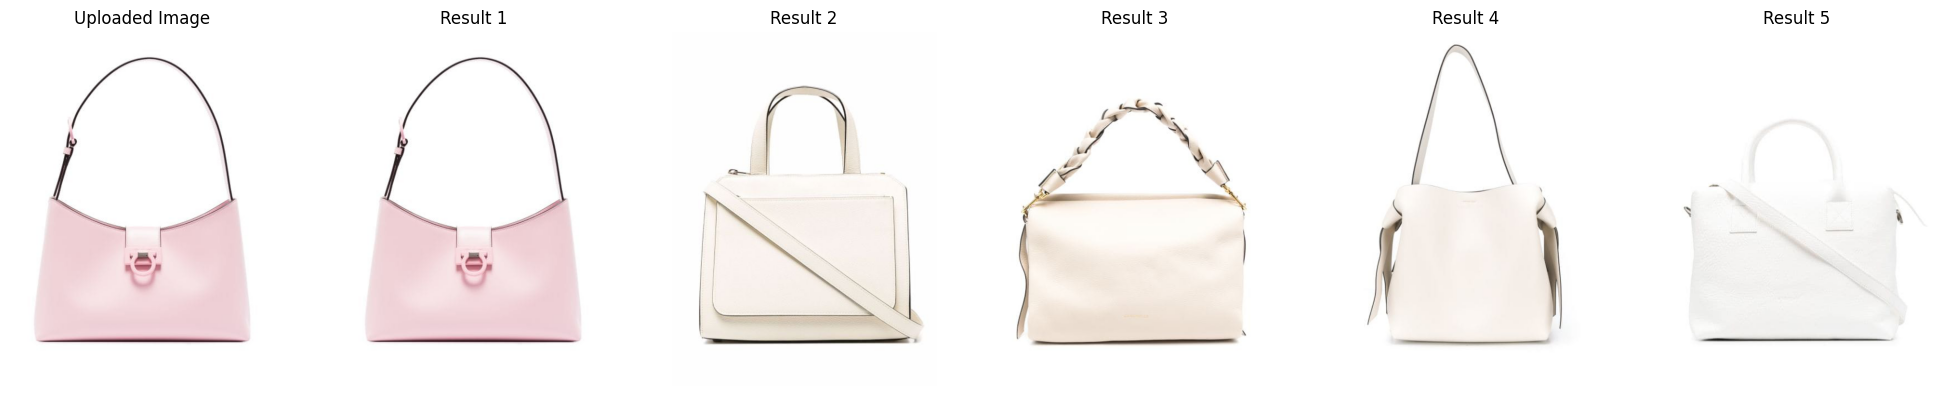

In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import faiss

# --- Upload image ---
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

def preprocess_image(img_path, size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist.flatten()

def get_shape_descriptor(image_path, size=(200, 200)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, size)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    return edges.flatten()

def get_bag_area(image_path):
    with Image.open(image_path) as img:
        return img.width * img.height

# Find the max area (for normalization) if needed
all_areas = [get_bag_area(p) for p in all_image_paths]
max_area = max(all_areas)

def normalized_area(image_path):
    return get_bag_area(image_path) / max_area

# --- Feature extraction for query image ---
query_img = preprocess_image(uploaded_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb = query_emb / np.linalg.norm(query_emb)

query_hist = get_color_histogram(uploaded_path)
query_shape = get_shape_descriptor(uploaded_path)
query_area = normalized_area(uploaded_path)

# --- Load FAISS index ---
faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')

# --- Search top 100 candidates ---
TOP_K = 100
D, I = faiss_index.search(query_emb.astype('float32'), k=TOP_K)
candidate_paths = [all_image_paths[idx] for idx in I[0]]

COLOR_DIST_THRESHOLD = 0.5
SHAPE_DIST_THRESHOLD = 60000
SIZE_RATIO_THRESHOLD = 1.5

filtered_results = []
for cand_path in candidate_paths:
    if cand_path == uploaded_path:
        continue  # Don't show the query image itself
    # Color filtering
    cand_hist = get_color_histogram(cand_path)
    color_dist = cv2.compareHist(query_hist.astype('float32'), cand_hist.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)
    # Shape filtering
    cand_shape = get_shape_descriptor(cand_path)
    shape_dist = np.sum(np.abs(query_shape - cand_shape))
    # Size filtering
    cand_area = normalized_area(cand_path)
    size_ratio = max(query_area / cand_area, cand_area / query_area)
    # All conditions
    if color_dist < COLOR_DIST_THRESHOLD and shape_dist < SHAPE_DIST_THRESHOLD and size_ratio < SIZE_RATIO_THRESHOLD:
        filtered_results.append(cand_path)
    if len(filtered_results) >= 5:
        break

# Fallback to top FAISS (embedding) results if not enough found
if len(filtered_results) < 5:
    for cand_path in candidate_paths:
        if cand_path != uploaded_path and cand_path not in filtered_results:
            filtered_results.append(cand_path)
        if len(filtered_results) >= 5:
            break

# --- Display Results ---
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(filtered_results):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving wbag17177.png to wbag17177.png


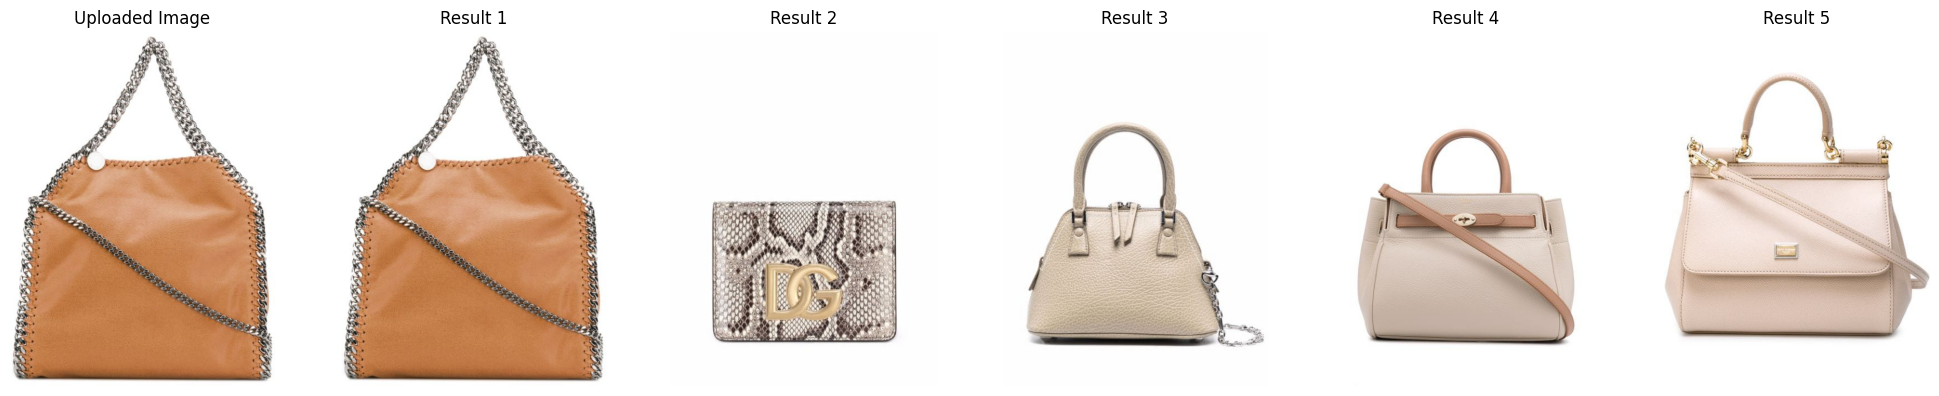

In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import faiss

# Upload image
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

# Preprocess image (must match training preprocessing)
def preprocess_image(img_path, size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Compute HSV color histogram
def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist.flatten()

# Compute Hu moments for shape similarity
def get_hu_moments(image_path, size=(200, 200)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    moments = cv2.moments(thresh)
    hu_moments = cv2.HuMoments(moments).flatten()
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    return hu_moments

# Compute normalized bag size (area/max_area)
def get_bag_area(image_path):
    with Image.open(image_path) as img:
        return img.width * img.height

all_areas = [get_bag_area(p) for p in all_image_paths]
max_area = max(all_areas)

def normalized_area(image_path):
    area = get_bag_area(image_path)
    return area / max_area

# Compute embedding for query image
query_img = preprocess_image(uploaded_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb /= np.linalg.norm(query_emb)

# Extract query features
query_hist = get_color_histogram(uploaded_path)
query_hu = get_hu_moments(uploaded_path)
query_area = normalized_area(uploaded_path)

# Load FAISS index
faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')
TOP_K = 100
D, I = faiss_index.search(query_emb.astype('float32'), k=TOP_K)
candidate_paths = [all_image_paths[idx] for idx in I[0]]

# Thresholds for filtering
COLOR_DIST_THRESH = 0.6   # Bhattacharyya distance, lower is stricter
SHAPE_DIST_THRESH = 0.5   # Euclidean distance between Hu moments
SIZE_RATIO_THRESH = 1.5   # Ratio of normalized sizes allowed

# Calculate distance functions
def color_dist(h1, h2):
    return cv2.compareHist(h1.astype('float32'), h2.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)

def shape_dist(v1, v2):
    return np.linalg.norm(v1 - v2)

filtered_results = []
scores = []

for cand_path in candidate_paths:
    if cand_path == uploaded_path:
        continue

    c_hist = get_color_histogram(cand_path)
    c_hu = get_hu_moments(cand_path)
    c_area = normalized_area(cand_path)

    cd = color_dist(query_hist, c_hist)
    sd = shape_dist(query_hu, c_hu)
    sr = max(query_area / c_area, c_area / query_area)

    if cd < COLOR_DIST_THRESH and sd < SHAPE_DIST_THRESH and sr < SIZE_RATIO_THRESH:
        filtered_results.append(cand_path)
        # Calculate combined score (weighted sum; lower is better)
        combined_score = 0.4 * cd + 0.4 * sd + 0.2 * (sr-1)
        scores.append(combined_score)

    if len(filtered_results) >= 5:
        break

# If fewer than 5 filtered results, fill from top FAISS results ignoring filters
if len(filtered_results) < 5:
    for cand_path in candidate_paths:
        if cand_path != uploaded_path and cand_path not in filtered_results:
            filtered_results.append(cand_path)
            scores.append(float('inf'))  # deprioritize non-filtered
        if len(filtered_results) >= 5:
            break

# Sort filtered results by combined score
if scores:
    sorted_indices = np.argsort(scores)
    filtered_results = [filtered_results[i] for i in sorted_indices]

# Display
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(filtered_results[:5]):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving wbag17106.png to wbag17106.png


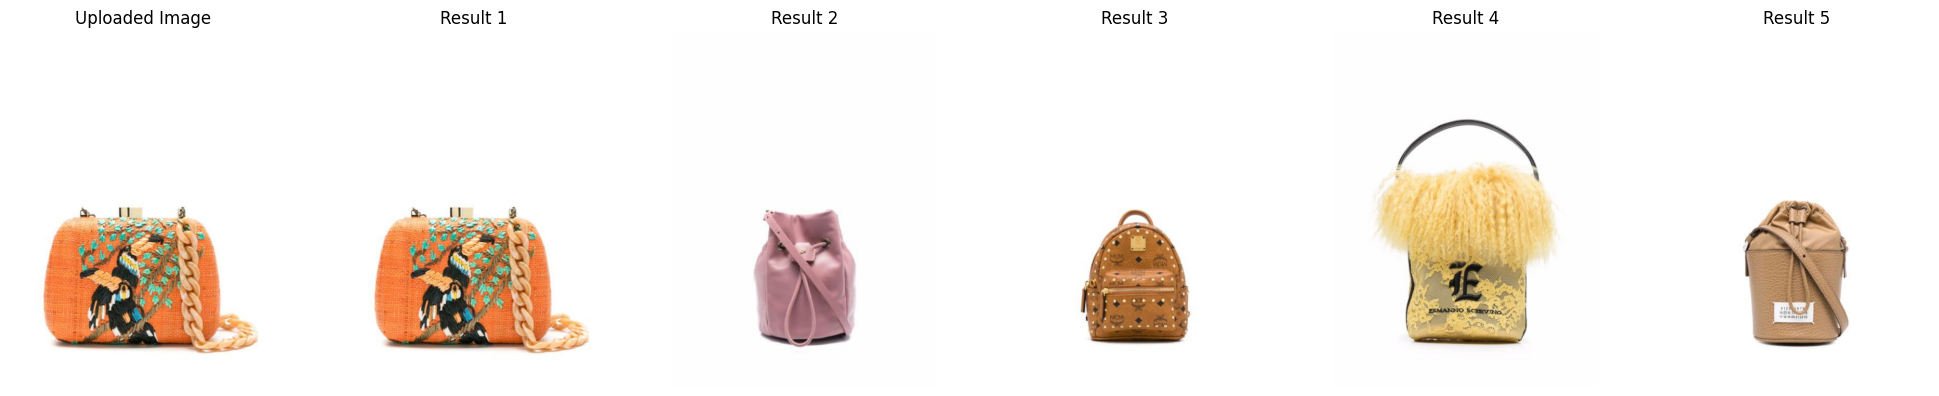

In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import faiss

# Upload image
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

# Preprocess image for embedding (if needed)
def preprocess_image(img_path, size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# HSV color histogram feature
def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist.flatten()

# Get query features
query_hist = get_color_histogram(uploaded_path)

# Load FAISS index and search top candidates
query_img = preprocess_image(uploaded_path)
query_img = tf.expand_dims(query_img, 0)
query_emb = embedding_model(query_img, training=False).numpy()
query_emb /= np.linalg.norm(query_emb)

faiss_index = faiss.read_index('/content/drive/MyDrive/bags_fashion_index_new.faiss')
TOP_K = 150
D, I = faiss_index.search(query_emb.astype('float32'), k=TOP_K)
candidate_paths = [all_image_paths[idx] for idx in I[0]]

COLOR_DIST_THRESHOLD = 0.6  # Looser is more inclusive

filtered_results = []
for cand_path in candidate_paths:
    if cand_path == uploaded_path:
        continue
    cand_hist = get_color_histogram(cand_path)
    color_dist = cv2.compareHist(query_hist.astype('float32'), cand_hist.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)
    if color_dist < COLOR_DIST_THRESHOLD:
        filtered_results.append(cand_path)
    if len(filtered_results) >= 5:
        break

# If less than 5, fill with top FAISS results for always 5 outputs
if len(filtered_results) < 5:
    for cand_path in candidate_paths:
        if cand_path != uploaded_path and cand_path not in filtered_results:
            filtered_results.append(cand_path)
        if len(filtered_results) >= 5:
            break

# Display uploaded and 5 color-matched images
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(filtered_results):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving OIP (1).jpeg to OIP (1).jpeg


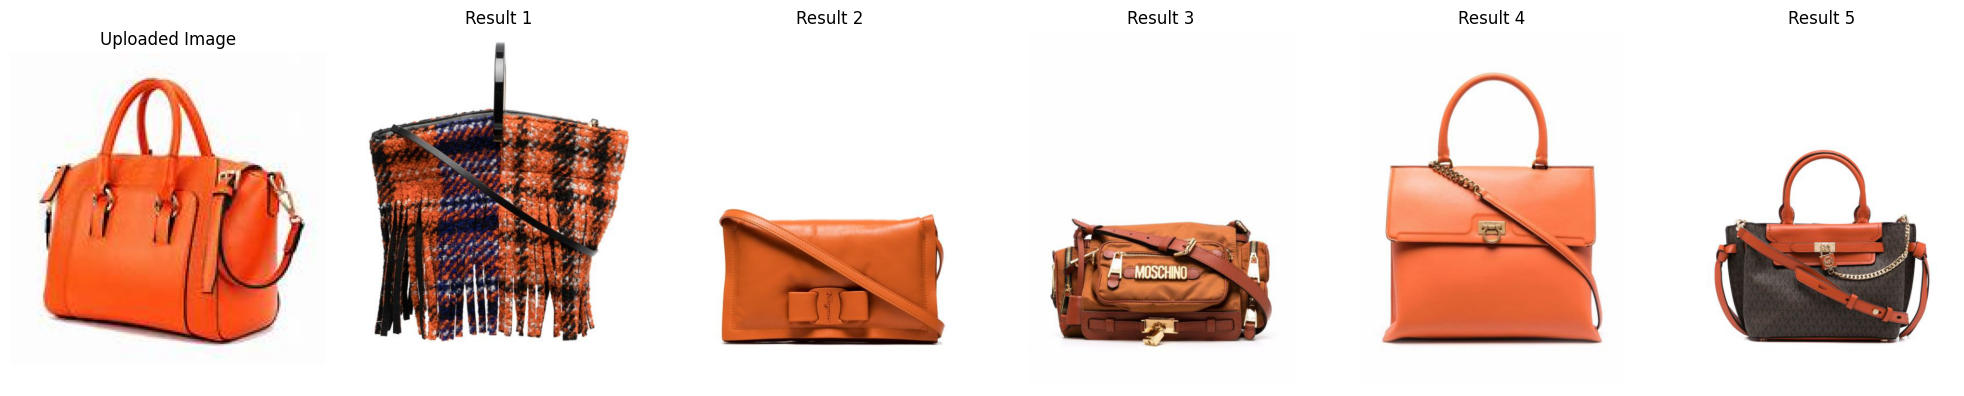

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Upload query image
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

# List your dataset image paths (all_image_paths should be defined)
# all_image_paths = [...] # e.g., loaded as before

def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist.flatten()

query_hist = get_color_histogram(uploaded_path)

color_dists = []
for img_path in all_image_paths:
    if img_path == uploaded_path:
        continue
    cand_hist = get_color_histogram(img_path)
    dist = cv2.compareHist(query_hist.astype('float32'), cand_hist.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)
    color_dists.append((dist, img_path))

color_dists.sort()  # ascending order: most similar colors first
top_results = [img_path for dist, img_path in color_dists[:5]]

# Display results
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(top_results):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving OIP (1).jpeg to OIP (1) (1).jpeg


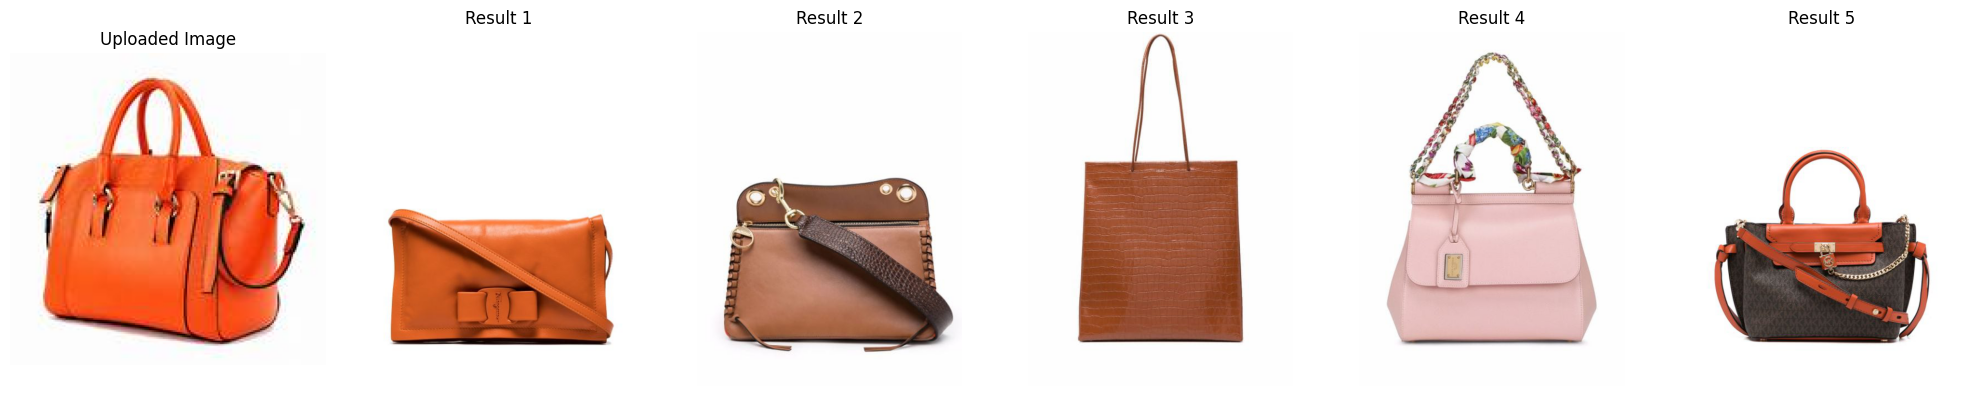

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Upload query image
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

# List your dataset image paths (all_image_paths must be defined beforehand)
# all_image_paths = [...] # e.g., loaded as before

# HSV color histogram feature
def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist.flatten()

# Shape feature using Hu moments
def get_hu_moments(image_path, size=(200, 200)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    # Use Otsu to robustly binarize various backgrounds
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    moments = cv2.moments(thresh)
    hu = cv2.HuMoments(moments).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    return hu

query_hist = get_color_histogram(uploaded_path)
query_hu = get_hu_moments(uploaded_path)

distances = []  # (score, img_path) pairs

for img_path in all_image_paths:
    if img_path == uploaded_path:
        continue
    cand_hist = get_color_histogram(img_path)
    cand_hu = get_hu_moments(img_path)
    color_dist = cv2.compareHist(query_hist.astype('float32'), cand_hist.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)
    shape_dist = np.linalg.norm(query_hu - cand_hu)
    # Combined score: color weighted higher than shape
    score = 0.7 * color_dist + 0.3 * shape_dist
    distances.append((score, img_path))

# Sort and pick top 5
distances.sort()
top_results = [img_path for score, img_path in distances[:5]]

# Display
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(top_results):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving OIP (1).jpeg to OIP (1) (2).jpeg


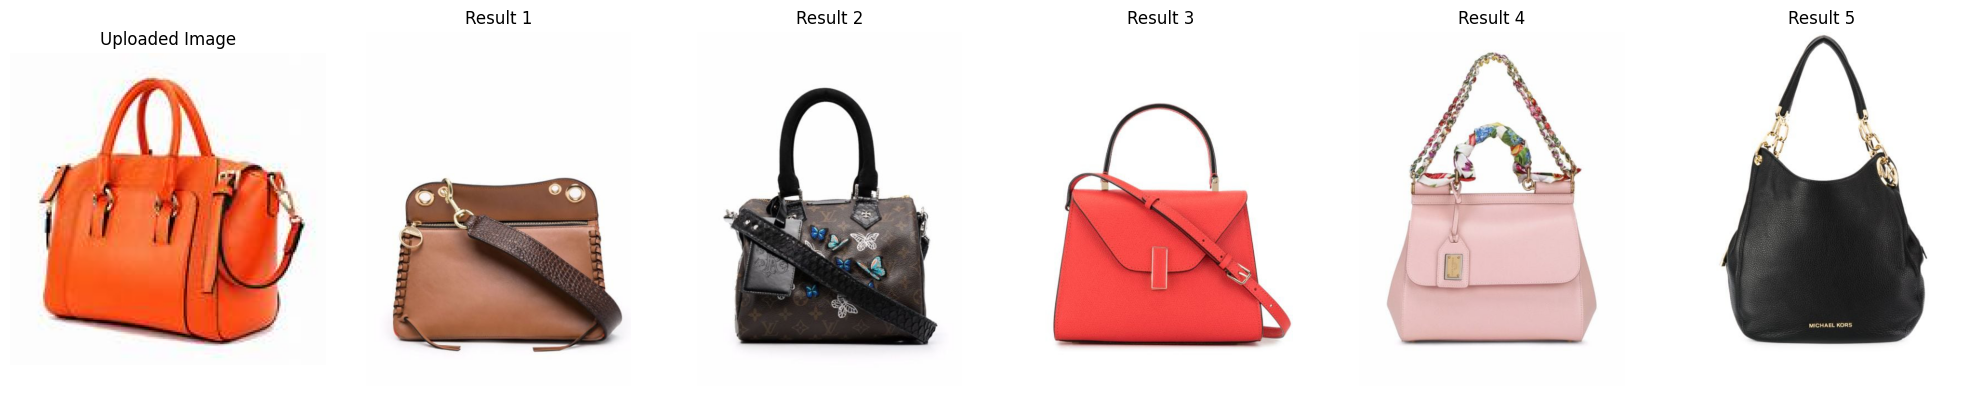

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Upload your query image
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

# Your dataset paths must be provided
# all_image_paths = [...]

def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def get_hu_moments(image_path, size=(200, 200)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    moments = cv2.moments(binary)
    hu = cv2.HuMoments(moments).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    return hu

query_hu = get_hu_moments(uploaded_path)
query_hist = get_color_histogram(uploaded_path)

# --- Step 1: Rank all by SHAPE similarity only
shape_ranks = []
for img_path in all_image_paths:
    if img_path == uploaded_path:
        continue
    cand_hu = get_hu_moments(img_path)
    shape_dist = np.linalg.norm(query_hu - cand_hu)
    shape_ranks.append((shape_dist, img_path))

shape_ranks.sort()
# Take N best shape candidates for color filtering/ranking
N = 30   # increase for diverse color within "good" shapes
best_shape_paths = [img_path for _, img_path in shape_ranks[:N]]

# --- Step 2: Within best shape matches, rank by COLOR
color_ranks = []
for img_path in best_shape_paths:
    cand_hist = get_color_histogram(img_path)
    color_dist = cv2.compareHist(query_hist.astype('float32'), cand_hist.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)
    color_ranks.append((color_dist, img_path))

color_ranks.sort()
top5 = [img_path for _, img_path in color_ranks[:5]]

# --- Display
plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, sim_path in enumerate(top5):
    plt.subplot(1, 6, i + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving OIP (1).jpeg to OIP (1) (3).jpeg


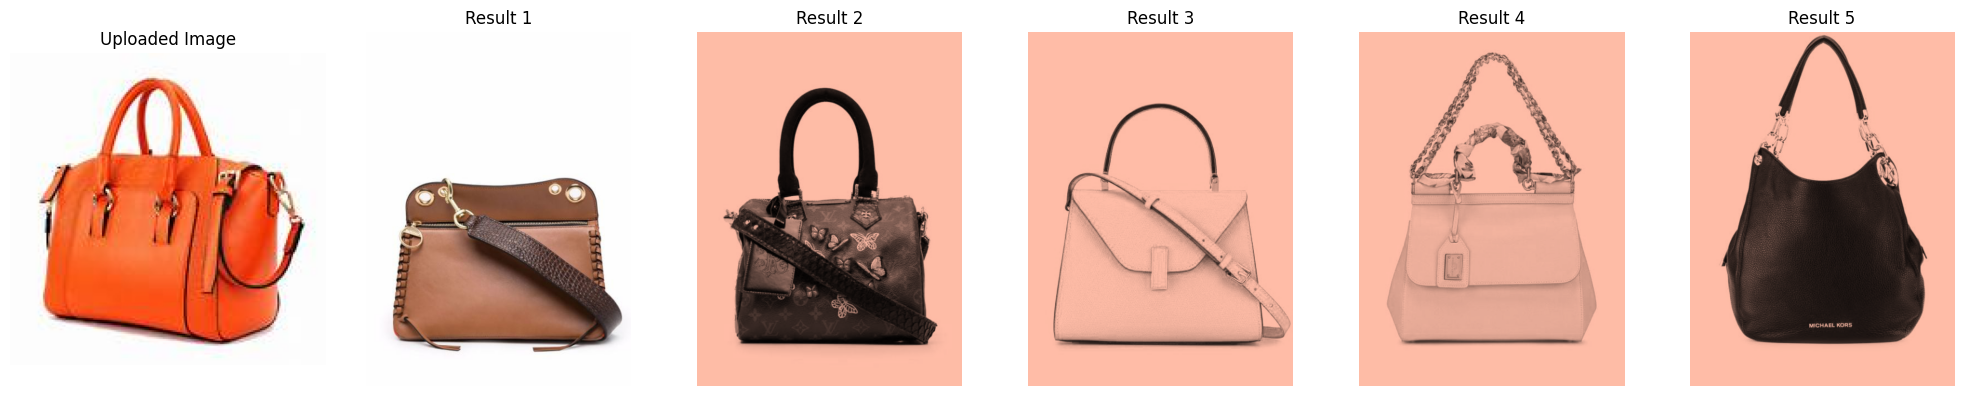

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage.color import rgb2hsv, hsv2rgb

# Upload your query image
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

def get_color_histogram(image_path, bins=(50, 60)):
    image = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1], None, bins, [0, 180, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def get_hu_moments(image_path, size=(200, 200)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    moments = cv2.moments(binary)
    hu = cv2.HuMoments(moments).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    return hu

def dominant_color(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image.reshape(-1, 3)
    avg = np.mean(pixels, axis=0)
    return avg.astype(np.uint8)

def recolor_image(src_path, target_rgb):
    image = cv2.imread(src_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = rgb2hsv(image / 255.)
    # Replace the hue/saturation with that of the target color
    target_hsv = rgb2hsv(np.ones_like(image) * target_rgb / 255.)
    hsv[..., 0] = target_hsv[0, 0, 0]
    hsv[..., 1] = target_hsv[0, 0, 1]
    recolored = (hsv2rgb(hsv) * 255).astype(np.uint8)
    return Image.fromarray(recolored)

query_hu = get_hu_moments(uploaded_path)
query_hist = get_color_histogram(uploaded_path)
query_color = dominant_color(uploaded_path)

# Rank all images by shape similarity
shape_ranks = []
for img_path in all_image_paths:
    if img_path == uploaded_path:
        continue
    cand_hu = get_hu_moments(img_path)
    shape_dist = np.linalg.norm(query_hu - cand_hu)
    shape_ranks.append((shape_dist, img_path))

# Take top-N by shape (strict)
shape_ranks.sort()
N = 30
best_shape_paths = [img_path for _, img_path in shape_ranks[:N]]

# Among these, sort by color (looser)
color_ranks = []
COLOR_MATCH_THRESHOLD = 0.55
for img_path in best_shape_paths:
    cand_hist = get_color_histogram(img_path)
    color_dist = cv2.compareHist(query_hist.astype('float32'), cand_hist.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)
    color_ranks.append((color_dist, img_path))

color_ranks.sort()
top5 = [img_path for color_dist, img_path in color_ranks[:5]]

# If color is NOT matched for all of top5, recolor those images
final_images = []
for i, (color_dist, img_path) in enumerate(color_ranks[:5]):
    if color_dist > COLOR_MATCH_THRESHOLD:
        # Recolor using HSV
        recolored = recolor_image(img_path, query_color)
        final_images.append(recolored)
    else:
        final_images.append(Image.open(img_path))

plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(uploaded_path))
plt.title('Uploaded Image')
plt.axis('off')

for i, img in enumerate(final_images):
    plt.subplot(1, 6, i + 2)
    plt.imshow(img)
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage.color import rgb2lab, lab2rgb

uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]

# Convert RGB image to LAB for color transfer
def image_to_lab(image):
    return rgb2lab(image / 255.0)

# Convert LAB image to RGB
def lab_to_image(lab):
    rgb = lab2rgb(lab)
    rgb = np.clip(rgb * 255, 0, 255).astype(np.uint8)
    return rgb

# Mask the bag region to avoid recoloring background
def get_bag_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    return mask

# Perform color transfer of src_img to target_img given mask, only on masked area
def color_transfer(src_img, target_img, mask):
    lab_src = image_to_lab(src_img)
    lab_target = image_to_lab(target_img)

    src_mean = lab_src[mask > 0].mean(axis=0)
    src_std = lab_src[mask > 0].std(axis=0)

    target_mean = lab_target[mask > 0].mean(axis=0)
    target_std = lab_target[mask > 0].std(axis=0)

    # Transfer color stats: normalize target, scale+shift by source
    transferred = lab_target.copy()
    for i in range(3): # For each channel L, A, B
        transferred[..., i] -= target_mean[i]
        transferred[..., i] = transferred[..., i] * (src_std[i] / (target_std[i] + 1e-10))
        transferred[..., i] += src_mean[i]

    # Convert back to RGB, clamp
    rgb_transferred = lab_to_image(transferred)

    out_img = target_img.copy()
    out_img[mask > 0] = rgb_transferred[mask > 0]
    return out_img

# Example usage: recolor result images exactly like query bag color
query_img = cv2.cvtColor(cv2.imread(uploaded_path), cv2.COLOR_BGR2RGB)
query_mask = get_bag_mask(query_img)

# Suppose top5 are paths to the top shape-matched bags you want to recolor
# top5 = [...]

recolored_results = []
for path in top5:
    tgt_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    tgt_mask = get_bag_mask(tgt_img)
    recolored = color_transfer(query_img, tgt_img, tgt_mask & query_mask) # intersection masks to keep proper bag region
    recolored_results.append(Image.fromarray(recolored))

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
plt.subplot(1, 6, 1)
plt.imshow(query_img)
plt.title('Uploaded Image')
plt.axis('off')

for i, img in enumerate(recolored_results):
    plt.subplot(1, 6, i + 2)
    plt.imshow(img)
    plt.title(f'Result {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving OIP (1).jpeg to OIP (1) (4).jpeg


ValueError: operands could not be broadcast together with shapes (641,480) (180,182) 